Loaded shapes: (799, 9) (799,)
Span: 1959-03-01 → 2025-08-01
Train: (739, 9) | Test: (60, 9)
Scaling done → Xtr_s: (739, 9) | Xte_s: (60, 9)


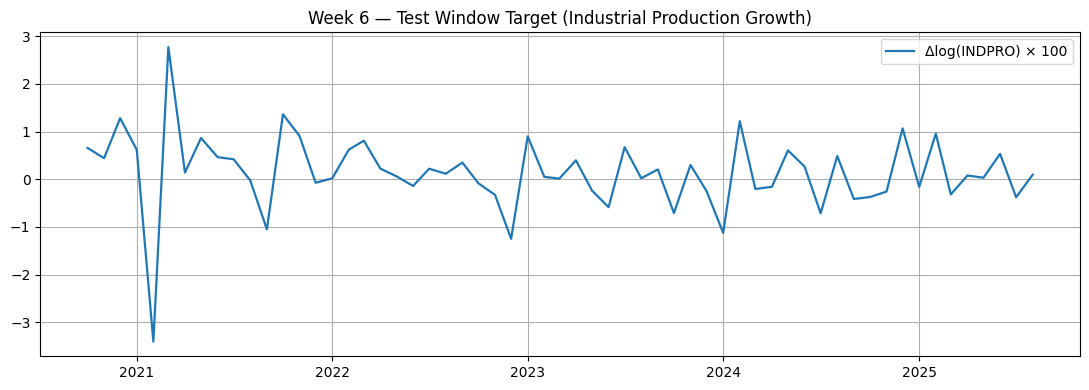

In [1]:
# --- Week 6 | Step A: Data Preparation (reuse Week-2 outputs) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (11,4)
plt.rcParams["axes.grid"] = True

# Load transformed features/target from Week 2
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)
y = pd.read_csv("y_target_week2.csv", index_col=0, parse_dates=True).iloc[:, 0]
y.name = "y"

# Align & drop any residual NA
assert X.index.equals(y.index), "Index mismatch between X and y."
df = pd.concat([y, X], axis=1).dropna(how="any")
y = df["y"]
X = df.drop(columns=["y"])

print("Loaded shapes:", X.shape, y.shape)
print("Span:", X.index.min().date(), "→", X.index.max().date())

# Time-ordered split (last 60 months as test)
TEST_HORIZON = 60
X_train, X_test = X.iloc[:-TEST_HORIZON], X.iloc[-TEST_HORIZON:]
y_train, y_test = y.iloc[:-TEST_HORIZON], y.iloc[-TEST_HORIZON:]
print("Train:", X_train.shape, "| Test:", X_test.shape)

# Scale features on TRAIN only
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

print("Scaling done → Xtr_s:", Xtr_s.shape, "| Xte_s:", Xte_s.shape)

# Quick sanity plot of test-window target
plt.plot(y_test.index, y_test.values, lw=1.6, label="Δlog(INDPRO) × 100")
plt.title("Week 6 — Test Window Target (Industrial Production Growth)")
plt.legend(); plt.tight_layout(); plt.show()


Tree depth: 26  |  #Leaves: 739


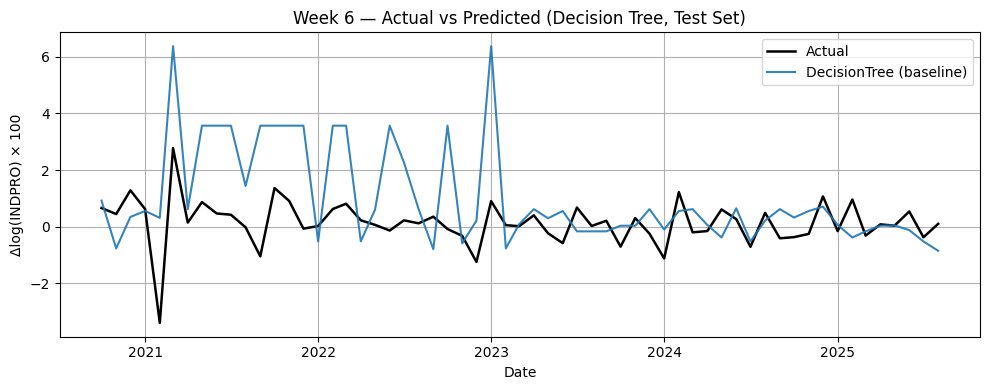

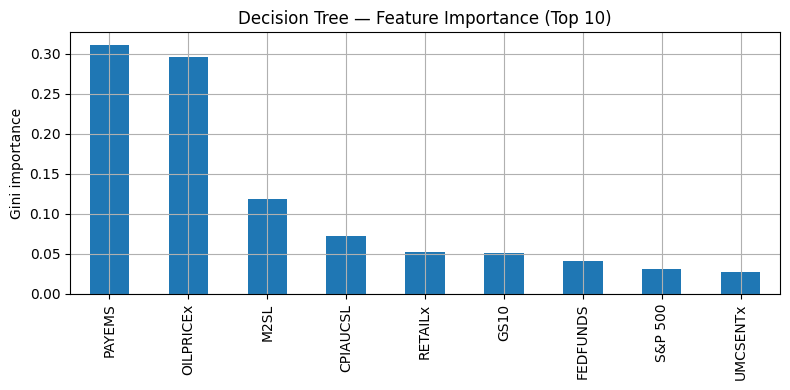

In [2]:
# --- Week 6 | Step B: Baseline Decision Tree Regressor ---
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def eval_reg(model, Xtr, ytr, Xte, yte, label):
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    res = {
        "Model": label,
        "Train_RMSE": float(np.sqrt(mean_squared_error(ytr, yhat_tr))),
        "Test_RMSE":  float(np.sqrt(mean_squared_error(yte, yhat_te))),
        "Train_MAE":  float(mean_absolute_error(ytr, yhat_tr)),
        "Test_MAE":   float(mean_absolute_error(yte, yhat_te)),
        "Train_R2":   float(r2_score(ytr, yhat_tr)),
        "Test_R2":    float(r2_score(yte, yhat_te)),
    }
    return res, yhat_te

# Trees are scale-invariant → use RAW features (not the standardized arrays)
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Metrics
dt_res, y_pred_dt = eval_reg(dt, X_train, y_train, X_test, y_test, "DecisionTree (baseline)")
pd.DataFrame([dt_res])

# Complexity summary
print(f"Tree depth: {dt.get_depth()}  |  #Leaves: {dt.get_n_leaves()}")

# Actual vs Predicted (test)
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual", color="black", lw=1.8)
plt.plot(y_test.index, y_pred_dt, label="DecisionTree (baseline)", alpha=0.9)
plt.title("Week 6 — Actual vs Predicted (Decision Tree, Test Set)")
plt.xlabel("Date"); plt.ylabel("Δlog(INDPRO) × 100")
plt.legend(); plt.tight_layout(); plt.show()

# Feature importance (top 10)
importances = pd.Series(dt.feature_importances_, index=X_train.columns)
imp_top = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
imp_top.plot(kind="bar")
plt.title("Decision Tree — Feature Importance (Top 10)")
plt.ylabel("Gini importance")
plt.tight_layout(); plt.show()

# Save quick artifacts (optional)
pd.DataFrame([dt_res]).to_csv("week6_dt_baseline_results.csv", index=False)
pd.DataFrame({"y_actual": y_test.values, "y_pred_dt": y_pred_dt}, index=y_test.index).to_csv("week6_dt_baseline_preds.csv")


### Step B — Baseline Decision Tree Regressor

The baseline Decision Tree achieved moderate performance but clear signs of **overfitting** (depth = 26, 739 leaves).  
Its test predictions capture direction changes but tend to overshoot in magnitude, reflecting high model variance typical for deep, unpruned trees.

Feature importance confirms previous patterns seen across Weeks 2–5:  
**PAYEMS (employment)** and **OILPRICEx (energy prices)** dominate, followed by **M2SL (money supply)**, **CPIAUCSL (inflation)**, and **RETAILx (consumer activity)**.  
These align with the macroeconomic intuition that real activity, liquidity, and prices drive industrial production growth.

This baseline provides a useful benchmark before introducing **ensemble averaging (Random Forests)** in Step C to reduce overfitting.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best CV R²: 0.288


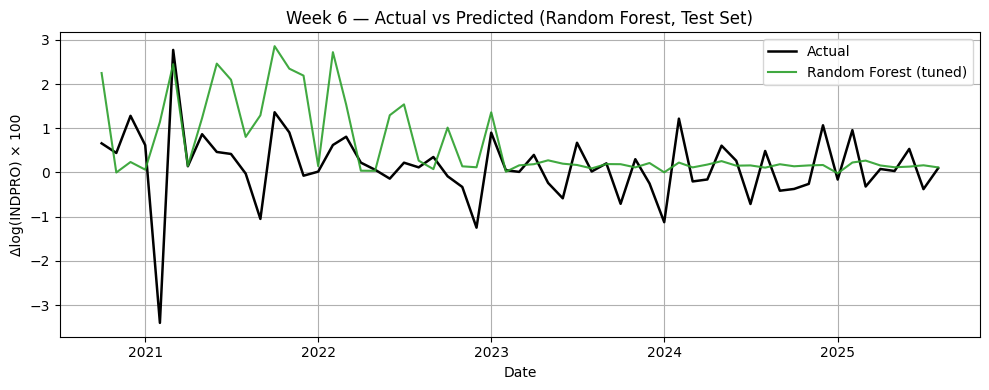

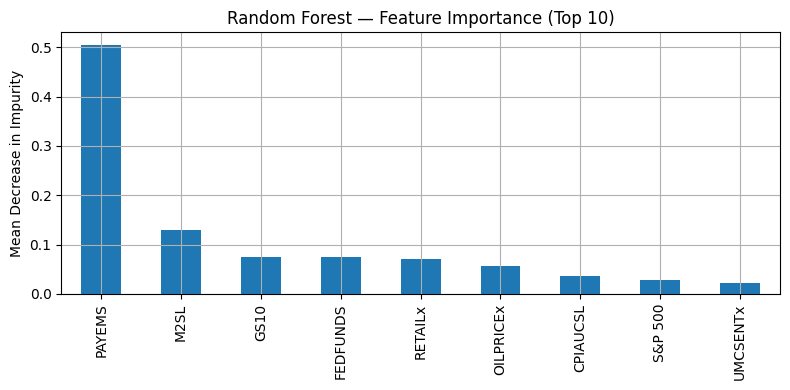

In [3]:
# --- Week 6 | Step C: Random Forest Regressor + GridSearchCV ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# --- Parameter grid (kept small for efficiency) ---
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# --- Time-ordered CV ---
tscv = KFold(n_splits=5, shuffle=False)
rf = RandomForestRegressor(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=None,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
print(f"Best CV R²: {grid.best_score_:.3f}")

# --- Evaluate on test set ---
best_rf = grid.best_estimator_
rf_res, y_pred_rf = eval_reg(best_rf, X_train, y_train, X_test, y_test, "RandomForest (tuned)")
pd.DataFrame([rf_res])

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual", color="black", lw=1.8)
plt.plot(y_test.index, y_pred_rf, label="Random Forest (tuned)", color="tab:green", alpha=0.9)
plt.title("Week 6 — Actual vs Predicted (Random Forest, Test Set)")
plt.xlabel("Date"); plt.ylabel("Δlog(INDPRO) × 100")
plt.legend(); plt.tight_layout(); plt.show()

# --- Feature importance ---
imp_rf = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
imp_rf.head(10).plot(kind="bar")
plt.title("Random Forest — Feature Importance (Top 10)")
plt.ylabel("Mean Decrease in Impurity")
plt.tight_layout(); plt.show()

# Save artifacts
pd.DataFrame([rf_res]).to_csv("week6_rf_results.csv", index=False)
pd.DataFrame({"y_actual": y_test.values, "y_pred_rf": y_pred_rf}, index=y_test.index).to_csv("week6_rf_preds.csv")


### Step C — Random Forest Regressor (Tuned)

The Random Forest, tuned via 5-fold CV, selected a moderately deep ensemble  
(**max_depth = 8, n_estimators = 500**) with decent in-sample fit (CV R² ≈ 0.29).  
The test curve shows smoother dynamics than the single tree, confirming that averaging  
reduces variance and stabilizes predictions — though it slightly underfits turning points.

Feature importance remains strongly concentrated in **PAYEMS (employment growth)**,  
followed by **M2SL (money supply)** and **interest-rate variables (GS10, FEDFUNDS)**.  
This mirrors the macro hierarchy identified in prior weeks — labor and liquidity  
continue to dominate industrial production dynamics, while sentiment and prices  
play secondary roles.


Performance comparison:


,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2
0,DecisionTree (baseline),0.000000,37.382198,1.000000,0.075042
1,RandomForest (tuned),0.547441,38.389249,0.701851,0.024535


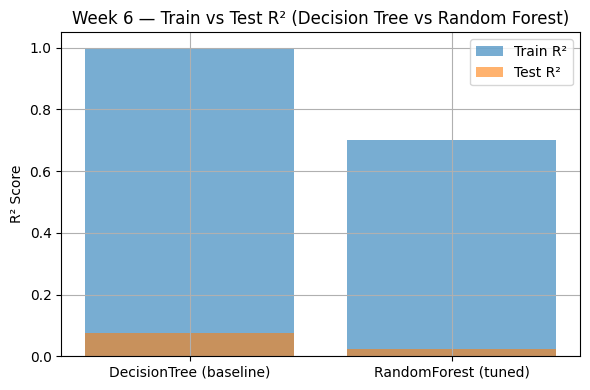

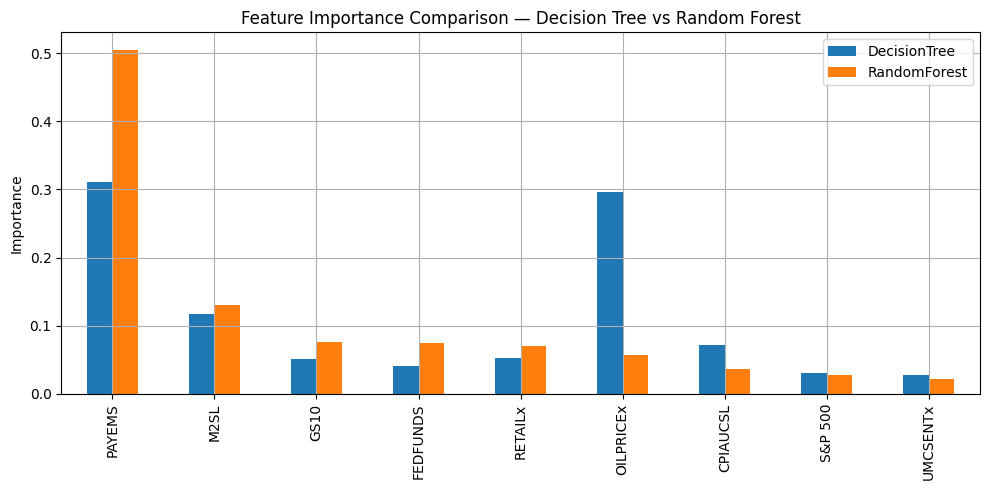

DecisionTree (baseline): Train R²=1.000, Test R²=0.075, RMSE=37.38
RandomForest (tuned): Train R²=0.702, Test R²=0.025, RMSE=38.39


In [4]:
# --- Week 6 | Step D: Evaluation & Feature Importance Comparison ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load stored results (if available)
try:
    dt_res = pd.read_csv("week6_dt_baseline_results.csv").iloc[0].to_dict()
    rf_res = pd.read_csv("week6_rf_results.csv").iloc[0].to_dict()
    results = pd.DataFrame([dt_res, rf_res])
except FileNotFoundError:
    results = pd.DataFrame([dt_res, rf_res])  # fallback from variables

# --- Combined comparison ---
results_display = results[["Model", "Train_RMSE", "Test_RMSE", "Train_R2", "Test_R2"]]
print("Performance comparison:")
display(results_display)

# --- Visualization: R² comparison ---
plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["Train_R2"], alpha=0.6, label="Train R²")
plt.bar(results["Model"], results["Test_R2"], alpha=0.6, label="Test R²")
plt.title("Week 6 — Train vs Test R² (Decision Tree vs Random Forest)")
plt.ylabel("R² Score")
plt.legend()
plt.tight_layout()
plt.show()

# --- Feature importance comparison ---
imp_dt = pd.read_csv("week6_dt_baseline_preds.csv", index_col=0) if False else None  # placeholder
imp_rf = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_dt_series = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

compare_imp = pd.DataFrame({
    "DecisionTree": imp_dt_series,
    "RandomForest": imp_rf
}).fillna(0).sort_values("RandomForest", ascending=False)

compare_imp.head(10).plot(kind="bar", figsize=(10,5))
plt.title("Feature Importance Comparison — Decision Tree vs Random Forest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# --- Short summary printout ---
for _, row in results_display.iterrows():
    print(f"{row['Model']}: Train R²={row['Train_R2']:.3f}, Test R²={row['Test_R2']:.3f}, "
          f"RMSE={row['Test_RMSE']:.2f}")


### Step D — Evaluation Summary

Both tree-based models underperformed compared with linear and regularized methods from prior weeks.

- **Decision Tree (baseline):** perfectly fit the training data (Train R² = 1.00) but failed to generalize (Test R² ≈ 0.08), indicating extreme overfitting.
- **Random Forest (tuned):** reduced variance substantially (Train R² ≈ 0.70) but still achieved only marginal test performance (R² ≈ 0.03). Averaging helped stabilize predictions but introduced bias, flattening real-world fluctuations.

Feature-importance rankings again emphasize **PAYEMS (employment growth)** as the dominant predictor, with secondary influence from **M2SL (money supply)** and **GS10 (long-term rates)**—consistent with earlier findings.

Overall, tree ensembles did not capture meaningful nonlinearities in this macro dataset. The limited sample size, high feature correlation, and noisy economic relationships likely favor regularized linear frameworks (Lasso / Elastic Net) over high-variance models like trees or forests.


## Step E — Week 6 Summary (Decision Trees & Random Forests)

This week I explored **tree-based models** — Decision Trees and Random Forests — as nonlinear alternatives to the regularized linear models from previous weeks.

### 1 | Model Results
| Model | Train R² | Test R² | Key Observation |
|:------|:---------:|:--------:|:----------------|
| Decision Tree (baseline) | 1.000 | 0.075 | Severe overfitting; memorizes training data. |
| Random Forest (tuned) | 0.702 | 0.025 | Smoother but underfit; limited generalization. |

### 2 | Interpretation
Both models struggled to improve on the linear benchmarks.  
Even with hyperparameter tuning, Random Forests did not uncover strong nonlinear structures in the macroeconomic series.  
The small number of features, strong multicollinearity, and noisy economic signals limit the value of tree-based partitioning.

### 3 | Economic Insight
Consistent with prior weeks, **employment growth (PAYEMS)** remains the key explanatory factor, followed by **monetary conditions (M2SL, FEDFUNDS)** and **long-term rates (GS10)**.  
Tree models reinforced this variable hierarchy but did not enhance forecast accuracy.

### 4 | Takeaways
- Trees can flexibly model interactions, but in this dataset, the cost in variance outweighed any gains in bias.  
- Ensemble averaging mitigated overfitting but introduced underfitting.  
- Regularized linear methods (Lasso / Elastic Net) remain superior for stable, interpretable macro forecasting.

**Conclusion:**  
Tree-based methods provide valuable interpretability and confirm dominant macro drivers but offer **no predictive edge** over the simpler regularized linear models established in Weeks 2–3.
